In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings("ignore")

from llama_index.core import (
    PropertyGraphIndex,
    SimpleDirectoryReader,
    Settings,
    StorageContext,
    load_index_from_storage
)
from llama_index.core.graph_stores import SimplePropertyGraphStore
from llama_index.core.indices.property_graph import (
    ImplicitPathExtractor,
    SimpleLLMPathExtractor
)
from llama_index.llms.groq import Groq
from llama_index.embeddings.ollama import OllamaEmbedding

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [3]:
Settings.llm = Groq("llama-3.3-70b-versatile")

In [4]:
Settings.embed_model=OllamaEmbedding(model_name="nomic-embed-text")

In [5]:
documents = SimpleDirectoryReader(input_files=["../docs/MBA_Worth_It.pdf"]).load_data(show_progress=True)

Loading files: 100%|██████████| 1/1 [00:00<00:00,  2.52file/s]


In [6]:
index = PropertyGraphIndex.from_documents(
    documents,
    kg_extractors = [
        ImplicitPathExtractor(),
        SimpleLLMPathExtractor(
            num_workers = 4,
            max_paths_per_chunk = 10,
        )
    ],
    show_progress=True
)

Parsing nodes:   0%|          | 0/7 [00:00<?, ?it/s]

Generating embeddings: 100%|██████████| 33/33 [00:03<00:00,  9.88it/s]


In [8]:
index.property_graph_store.save_networkx_graph(name="./kg.html")

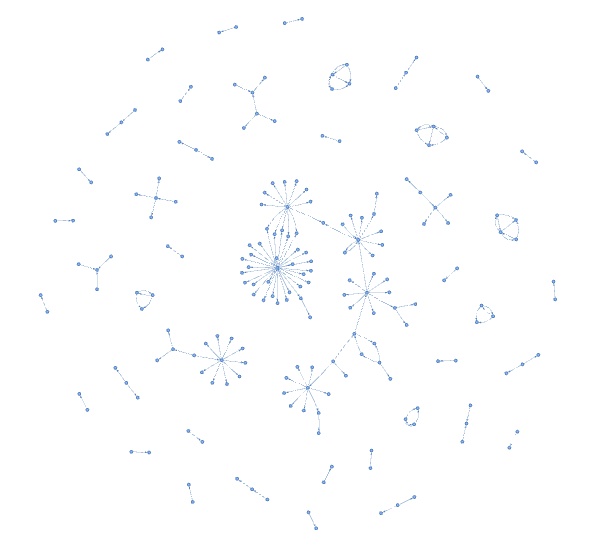

In [10]:
from IPython.display import Image

Image(filename="../images/Graph_Groq.png")

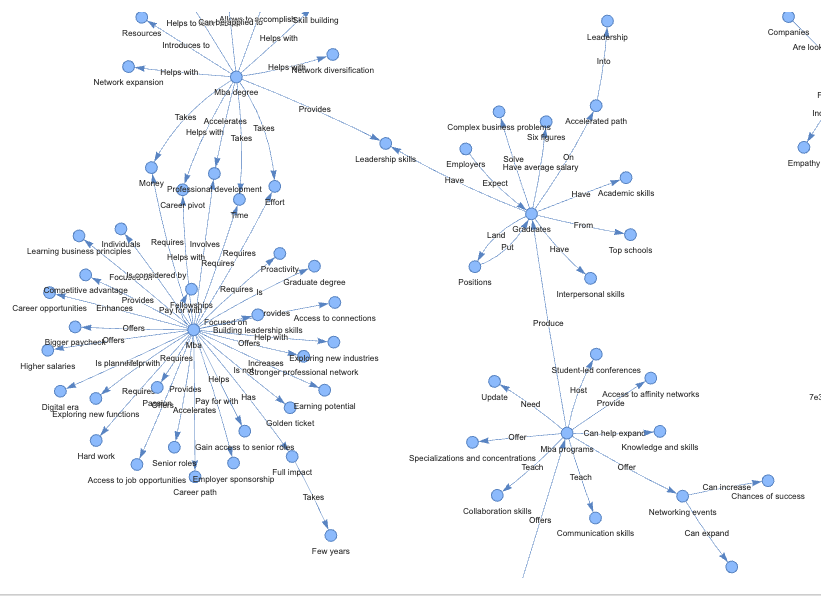

In [11]:
Image(filename="../images/Zoomed_Graph.png")

In [12]:
from IPython.display import HTML, display, Markdown

In [ ]:
HTML(filename="kg.html")

In [14]:
retriever = index.as_retriever(include_text=False)

In [16]:
nodes = retriever.retrieve("What are some reasons to take an MBA?")
for node in nodes:
    print(node.text)

Business school -> Provides -> Personal benefits
Business school -> Provides -> Professional benefits
Business school -> Provide -> Exposure to peers
Business school -> Provides -> Community of future leaders and well-connected alumni
Business school -> Offer -> Great time to gain exposure
Business school -> May not be -> Right step
Business school -> Provides -> Academic benefits
Business school -> Provide -> Exposure to faculty
Some students -> Come to -> Business school
Business school -> Provide -> Exposure to alumni
Applying to mba -> Requires -> More than just gaining money or power
Mba degree -> Helps with -> Network expansion
Mba degree -> Helps with -> Network diversification
Mba degree -> Helps with -> Skill building
Mba degree -> Allows to accomplish -> Career ambitions
Mba degree -> Helps to learn about -> New industry
Mba degree -> Can be applied to -> Most industries
Mba degree -> Provides -> Leadership skills
Mba degree -> Helps with -> Career pivot
Mba degree -> Acceler

In [17]:
query_engine = index.as_query_engine(include_text=True)

response = query_engine.query("What are some reasons to take an MBA?")

display(Markdown(str(response)))

Some reasons to take an MBA include network expansion, network diversification, skill building, accomplishing career ambitions, learning about a new industry, and gaining leadership skills. Additionally, an MBA can be applied to most industries, and it can help with career pivot and professional development. It can also provide access to resources and introduce students to a community of future leaders and well-connected alumni.

Storage

In [18]:
index.storage_context.persist(persist_dir="../graph_storage")

# Let's include a vector store!

In [19]:
from llama_index.core.vector_stores import SimpleVectorStore

In [20]:
vector_store = SimpleVectorStore()

In [ ]:
hybrid_index = PropertyGraphIndex.from_documents(
    documents,
    graph_store=SimplePropertyGraphStore(),
    vector_store=vector_store,
    kg_extractors = [
        ImplicitPathExtractor(),
        SimpleLLMPathExtractor(
            num_workers = 4,
            max_paths_per_chunk = 10,
        )
    ],
    show_progress=True,
)

In [23]:
hybrid_index.storage_context.persist("../hybrid_storage")

In [24]:
hybrid_index.property_graph_store.save_networkx_graph(name="./kg2.html")

## Reload index

In [25]:
reload_index = PropertyGraphIndex.from_existing(
    SimplePropertyGraphStore.from_persist_dir("../hybrid_storage"),
    vector_store = SimpleVectorStore.from_persist_dir("../hybrid_storage"),
)

In [26]:
query_engine2 = reload_index.as_query_engine(
    include_text=True,
    similarity_top_k=6,
)

In [27]:
response = query_engine2.query("What are some considerations when deciding whether or not to embark on an MBA?")

display(Markdown(str(response)))

When considering an MBA, it's essential to reflect on your motivations and goals. Ask yourself why you want to pursue an MBA and what you hope to achieve. Is it to accelerate your career path, gain access to senior roles, or transition into a new industry? It's crucial to ensure that your motivations align with your long-term career objectives. 

Before making a decision, take time to reflect on your current situation and where you want to go. Consider what skills you need to develop and how an MBA can help you achieve your goals. It's also important to weigh the costs and benefits of an MBA program, including the financial investment and the time commitment required.

Ultimately, pursuing an MBA should be a deliberate and well-thought-out decision, driven by a clear understanding of your career aspirations and how the program can help you achieve them. By taking the time to reflect on your goals and motivations, you can make an informed decision that aligns with your long-term career objectives.

In [28]:
response = query_engine2.query("What are the right and wrong motivations for an MBA?")

display(Markdown(str(response)))

The right motivations for pursuing an MBA involve a genuine desire for personal and professional growth, such as satisfying personal ambitions, accelerating career paths, and gaining access to more senior roles. It's about having a passion for learning and a willingness to challenge oneself academically, professionally, and personally. Participating in volunteer programs to build skills and networks can be a valuable aspect of this journey, as it allows individuals to apply theoretical knowledge in practical settings and foster meaningful connections. 

On the other hand, wrong motivations for an MBA include being driven solely by financial gain or the desire for power, without considering the broader implications of the program. Relying solely on financial support from others without a personal commitment to the program is also an incorrect motivation. It's essential to be "all in" and dedicated to the MBA experience, as there are alternative and potentially less costly ways to acquire new skills and knowledge. Ultimately, the decision to pursue an MBA should be based on a thoughtful consideration of both the costs and the benefits, recognizing that while cost is an important factor, it shouldn't be the sole deciding factor.